<a href="https://colab.research.google.com/github/perumalkabali/Pediatric_Brain_Cancer_Classification/blob/main/Pediatric_Brain_Cancer_Classification_codebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install getpass4 jupyter_ai~=1.0 openai gseapy

### **Configuring OpenAI API keys**

In [45]:
import os
import openai
from getpass import getpass
api_key = getpass("Enter your OpenAI key: ") #https://platform.openai.com/api-keys
os.environ['OPENAI_API_KEY'] = api_key

Enter your OpenAI key: ··········




```
# This is formatted as code
```

### **Setting up Jupyter copilot**

In [ ]:
!pip install langchain_anthropic langchain_openai langchain_google_genai langchain_nvidia_ai_endpoints

In [ ]:
!pip install jupyter-ai

In [3]:
%load_ext jupyter_ai

### **Let's begin, we will load our dataset now**

> Add blockquote



In [ ]:
!pip install gdown
import gdown

In [63]:
url = 'https://drive.google.com/uc?id=1-Bu8-CxlIzkKKhh0AGr47HN5kYfDQWKx'
output = 'PediatricBrainCancer_Data.csv'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1-Bu8-CxlIzkKKhh0AGr47HN5kYfDQWKx
To: /content/PediatricBrainCancer_Data.csv
100%|██████████| 1.19M/1.19M [00:00<00:00, 73.4MB/s]


'PediatricBrainCancer_Data.csv'

In [64]:
import pandas as pd
gene_exp = pd.read_csv(output, index_col=0)
gene_exp.head()

,ENTPD4,PPM1E,ANKRD34C,PRR16,LONP1,LPA,DALRD3,ZNF705G,SMAD6,ATF6,...,NR2F2,AS3MT,PCDH11Y,FAM124B,ASH2L,PCED1B,CA1,ZBTB22,CBLL1,Clinical_status
7316-101,3.432311,2.672589,0.341457,1.711063,4.543091,0.386900,3.165207,0.019529,1.137224,2.621226,...,3.917738,1.208563,3.630702,0.633061,3.721078,1.755051,0.233654,3.259843,3.222730,GNG
7316-120,3.339354,2.435612,0.047633,1.092421,3.917665,0.160108,2.281124,-0.102926,0.960577,3.336697,...,2.774818,2.004762,-0.060282,0.768917,3.836300,1.520004,0.361742,2.830646,3.457789,GNG
7316-156,3.219657,0.811430,0.265461,0.943533,5.676209,0.322045,3.316833,0.265461,2.164637,2.976956,...,3.498122,1.874270,0.279816,0.552342,3.709068,2.781476,0.467095,3.301085,3.316833,GNG
7316-1793,4.007827,2.650892,0.078530,0.331072,4.220304,0.040395,2.523059,-0.123104,1.277434,3.567313,...,2.933479,1.163777,-0.123104,0.509164,3.730892,2.601546,0.221724,2.999569,3.697585,GNG
7316-1854,3.431670,2.272258,0.210982,0.869548,4.122634,0.033586,2.865766,-0.064025,1.363581,3.050342,...,1.943171,1.701510,2.643058,0.347401,3.555388,1.263662,0.112298,3.129747,3.603867,GNG


### **Differentially expressed genes using t test between the two clinical conditions given the data is normalized**

In [86]:
%%ai openai-chat:gpt-3.5-turbo --format code
You are a bioinformatician, having experience with python programming language. You are given a gene expression data where each is a
sample and each column is gene expression value. The last column is Clinical_status which is a categorical variable with classes GNG and MBL.
Design a function to perform t-test between the two classes for each gene, and return the results as a dataframe with t-statistic and p-value
in columns.

In [67]:
import pandas as pd
from scipy import stats

def perform_t_test(data):
    t_statistic = []
    p_value = []
    genes = data.columns[:-1]  # Exclude the last column (Clinical_status)
    for gene in genes:
        group1 = data[data['Clinical_status'] == 'GNG'][gene]
        group2 = data[data['Clinical_status'] == 'MBL'][gene]
        t, p = stats.ttest_ind(group1, group2)
        t_statistic.append(t)
        p_value.append(p)
    results = pd.DataFrame({'Gene': genes, 'T-Statistic': t_statistic, 'P-Value': p_value})
    return results

# Example usage
t_test_results = perform_t_test(data = gene_exp)
t_test_results.head()

,Gene,T-Statistic,P-Value
0,ENTPD4,1.929813,0.062535
1,PPM1E,2.654832,0.012261
2,ANKRD34C,2.050770,0.048553
3,PRR16,2.664717,0.011971
4,LONP1,0.300681,0.765602


### **Differentially expressed genes with t-test and log fold change calculation**

In [87]:
%%ai openai-chat:gpt-3.5-turbo --format code
You are a bioinformatician, having experience with python programming language. You are given a gene expression data where each is a
sample and each column is gene expression value. The last column is Clinical_status which is a categorical variable with classes
GNG and MBL. Design a function to perform t-test and the log fold change between the two classes for each gene, and return the results
as a dataframe with t-statistic and p-value in columns.

In [68]:
import pandas as pd
import scipy.stats as stats

def perform_t_test(data):
    # Separate the gene expression data and clinical status
    gene_data = data.iloc[:, :-1]
    clinical_status = data.iloc[:, -1]

    # Initialize an empty dataframe to store results
    #result_df = pd.DataFrame(columns=['Gene', 't-statistic', 'p-value', 'LFC'])
    col_names = ['Gene', 't-statistic', 'p-value', 'LFC']
    results = []

    # Iterate over each gene
    for gene in gene_data.columns:
        # Split the gene expression data based on clinical status
        group1 = gene_data[clinical_status == 'GNG'][gene]
        group2 = gene_data[clinical_status == 'MBL'][gene]

        # Perform t-test
        t_statistic, p_value = stats.ttest_ind(group1, group2)

        # Calculate log fold change
        log_fold_change = group2.mean() - group1.mean()

        # Append the result to the dataframe
        results.append([gene, t_statistic, p_value, log_fold_change])

    result_df = pd.DataFrame(results, columns=col_names)
    return result_df

# Example usage
t_test_results = perform_t_test(data = gene_exp)
t_test_results.head()

,Gene,t-statistic,p-value,LFC
0,ENTPD4,1.929813,0.062535,-0.213811
1,PPM1E,2.654832,0.012261,-0.812095
2,ANKRD34C,2.050770,0.048553,-0.145653
3,PRR16,2.664717,0.011971,-0.478615
4,LONP1,0.300681,0.765602,-0.067598


#### **Volcano plot**

In [88]:
%%ai openai-chat:gpt-3.5-turbo --format code
Design a python function to build a volcano plot from a dataframe with columns Gene, p-value and LFC. Indicate those genes
as differentially expressed for which abs(logfc)>1 and p-value<0.05. Also, show upregulated genes in red and downregulated genes
in blue. Do not forget to show all the genes

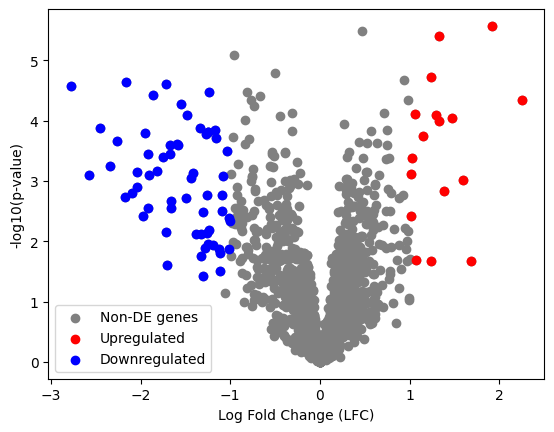

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def volcano_plot(df):
    # Filter differentially expressed genes
    df_de = df[(abs(df['LFC']) > 1) & (df['p-value'] < 0.05)]

    # Plot all genes
    plt.scatter(df['LFC'], -1 * np.log10(df['p-value']), color='gray', label='Non-DE genes')

    # Plot upregulated genes in red
    plt.scatter(df_de[df_de['LFC'] > 0]['LFC'], -1 * np.log10(df_de[df_de['LFC'] > 0]['p-value']), color='red', label='Upregulated')

    # Plot downregulated genes in blue
    plt.scatter(df_de[df_de['LFC'] < 0]['LFC'], -1 * np.log10(df_de[df_de['LFC'] < 0]['p-value']), color='blue', label='Downregulated')

    # Add labels and legend
    plt.xlabel('Log Fold Change (LFC)')
    plt.ylabel('-log10(p-value)')
    plt.legend()

    # Show plot
    plt.show()
volcano_plot(t_test_results)

#### **Filetering differentially expressed genes**

In [73]:
%%ai openai-chat:gpt-3.5-turbo --format code
Write a Python function to filter out only the differentially expressed genes froma dataframe with columns Gene, p-value and LFC.
Genes having abs(LFC)>1 and p-value<0.05 should be considered as differentially expressed.Return the results as a list. Write the
code using Pandas conditional rules in a single line.

In [74]:
def get_differentially_expressed_genes(df):
    return df[(df['LFC'].abs() > 1) & (df['p-value'] < 0.05)]['Gene'].tolist()
diff_expressed_genes = get_differentially_expressed_genes(t_test_results)
diff_expressed_genes

['DAB2',
 'SYT1',
 'HLA-DOA',
 'RAB3A',
 'PNMA3',
 'RGS6',
 'PTGFRN',
 'TRPM8',
 'PLA2R1',
 'VWA5B2',
 'AP3B2',
 'ZNF536',
 'NAPB',
 'KNDC1',
 'STON1',
 'CTSO',
 'RAB3B',
 'EPHA10',
 'ICAM5',
 'SFRP4',
 'TUBA4A',
 'TMEM132C',
 'PLCH2',
 'MYT1L',
 'TIMP4',
 'ANKRD18A',
 'UNC13A',
 'GALNT13',
 'UNC5D',
 'UST',
 'SYT13',
 'LY6H',
 'ETNPPL',
 'ROGDI',
 'CNDP1',
 'KHDRBS2',
 'RASGRP1',
 'LDB3',
 'HPCAL4',
 'SMIM43',
 'SYTL4',
 'CDH8',
 'CELF3',
 'KALRN',
 'STX1B',
 'SULT4A1',
 'MAPK8IP2',
 'PXDC1',
 'NEFM',
 'PRSS3',
 'SEZ6L2',
 'BTN3A2',
 'CPLX1',
 'FAM153A',
 'LPAR1',
 'RAPGEF4',
 'RPH3A',
 'PGM2L1',
 'EFHD1',
 'HRH3',
 'DUSP8',
 'PTPN5',
 'AMER2',
 'DLGAP2',
 'MARCH4',
 'ABHD2',
 'SEZ6',
 'SNAP25',
 'TUBB3',
 'SPHKAP',
 'PITPNM3',
 'DLG4',
 'TMEM151B',
 'GPR37',
 'GABRB1',
 'COX7A1',
 'CDKL1']

#### **PCA analysis**

In [75]:
%%ai openai-chat:gpt-3.5-turbo --format code
Write a Python function that takes a list of features and dataframe as an input. The dataframe contains features as columns except
for the last column which is a categorical variable.

First, filter out the columns in the dataframe using the provided list of features.

Then perform PCA upon the filtered data and visualize the PC_1 and PC_2. Color the samples as per the categorical variable.

Use Seaborn for visualization

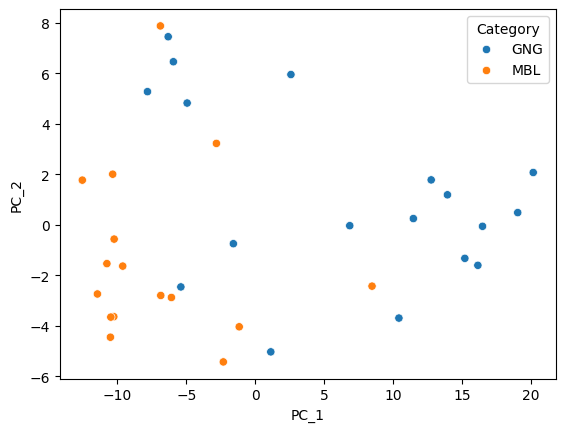

In [76]:
import pandas as pd
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

def plot_pca(features, data):
    filtered_data = data[features]
    pca = PCA(n_components=2)
    pca_data = pca.fit_transform(filtered_data)
    pca_df = pd.DataFrame(data=pca_data, columns=['PC_1', 'PC_2'])
    pca_df['Category'] = list(data.iloc[:, -1])
    sns.scatterplot(data=pca_df, x='PC_1', y='PC_2', hue='Category')
    plt.show()
plot_pca(diff_expressed_genes, gene_exp)

#### **Enrichment analysis**

In [77]:
%%ai openai-chat:gpt-3.5-turbo --format code
Write a Python function to perform enrichment analysis using gseapy package. The inputs to the function
should be differentially expressed genes.

In [78]:
def perform_enrichment_analysis(differentially_expressed_genes):
    import gseapy

    # Set up the required inputs for gseapy
    gene_list = differentially_expressed_genes
    gene_sets = 'GO_Biological_Process_2018'
    organism = 'human'
    enrichment_method = 'gseapy.prerank'

    # Perform enrichment analysis
    enr_results = gseapy.enrichr(gene_list=gene_list, gene_sets=gene_sets, organism=organism,
                                )

    return enr_results

# Example usage:
enrichment_results = perform_enrichment_analysis(diff_expressed_genes)
enrichment_results.results

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2018,regulation of regulated secretory pathway (GO:...,5/37,2.934856e-07,0.000073,0,0,43.166233,649.282187,RPH3A;RAB3A;SYT1;SYT13;SYTL4
1,GO_Biological_Process_2018,organelle membrane fusion (GO:0090174),6/71,3.135849e-07,0.000073,0,0,25.817551,386.622889,RPH3A;SNAP25;STX1B;SYT1;SYT13;SYTL4
2,GO_Biological_Process_2018,modulation of chemical synaptic transmission (...,6/82,7.414593e-07,0.000115,0,0,22.068569,311.490034,STX1B;UNC13A;SYT1;DLG4;MAPK8IP2;CPLX1
3,GO_Biological_Process_2018,regulation of exocytosis (GO:0017157),5/51,1.516580e-06,0.000129,0,0,30.007548,402.072714,RAB3B;RAB3A;SYT1;SYTL4;CPLX1
4,GO_Biological_Process_2018,chemical synaptic transmission (GO:0007268),9/289,1.656182e-06,0.000129,0,0,9.285032,123.593016,SNAP25;NAPB;GABRB1;UNC13A;SYT1;DLG4;DLGAP2;CPL...
...,...,...,...,...,...,...,...,...,...,...
462,GO_Biological_Process_2018,regulation of cellular macromolecule biosynthe...,1/631,9.156904e-01,0.923601,0,0,0.402945,0.035490,ZNF536
463,GO_Biological_Process_2018,regulation of transcription from RNA polymeras...,3/1478,9.305649e-01,0.936582,0,0,0.507045,0.036489,SFRP4;MYT1L;ZNF536
464,GO_Biological_Process_2018,regulation of cell proliferation (GO:0042127),1/740,9.454506e-01,0.949517,0,0,0.341571,0.019160,SFRP4
465,GO_Biological_Process_2018,"regulation of transcription, DNA-templated (GO...",3/1598,9.514552e-01,0.953497,0,0,0.465848,0.023182,DAB2;MYT1L;ZNF536


#### **Machine learning analysis**

In [79]:
%%ai openai-chat:gpt-3.5-turbo --format code
You are given a dataframe having features as columns with the last column being a binary categorical variable. Design a Python
function to build a loistic regression model that predicts the categorical variable. Split the data in training and test set
in the ration of 70:30. Report the test-set accuracy, AUROC, precision, and recall. Also plot the ROC curve.

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


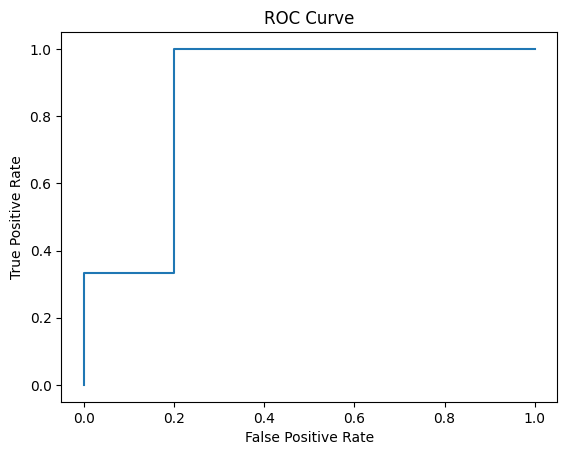

Test Set Accuracy: 0.7272727272727273
AUROC: 0.8666666666666667
Precision: 0.8
Recall: 0.6666666666666666


In [81]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, roc_curve
import matplotlib.pyplot as plt

def build_logistic_regression_model(df):
    X = df.iloc[:, :-1].values
    y = df.iloc[:, -1].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    model = LogisticRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    auroc = roc_auc_score(y_test, y_pred_proba)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

    return accuracy, auroc, precision, recall

# Example usage:
gene_exp.replace({'GNG':0, 'MBL':1}, inplace = True)
accuracy, auroc, precision, recall = build_logistic_regression_model(gene_exp)
print("Test Set Accuracy:", accuracy)
print("AUROC:", auroc)
print("Precision:", precision)
print("Recall:", recall)